# APPM 4720 Applied Deep Learning
## Progress Report 05 - Model Explanation
## Sabrina Liu, November 1, 2021
The primary objective of this progress report is to survey the popular CNN model explanation methods covered in lectures. There are many reasons for our wanting to inspect the inside of already-trained neural networks: 
1. we need to debug and improve our models when it's still being developed
2. we want to build trust and validate our models when it's established
3. we want to learn and extract new knowledge from the models once they become mature and scalable

In order to understand why a model makes a certain prediction on a specific instance, we need to go beyond the loss function and the metrics. Below listed methods are reviewed in terms of their mathematical background and implementation steps. In general, each method has its own advantages and disadvantages. Several different Python libraries are investigated to implement the model explanation methods.

|Method|Layer-Specific|Pixel-Attribution|Class-Specific|Gradient-Based|Feature Localization|Model-Agnostic|
|---|:-:|:-:|:-:|:-:|:-:|:-:|
|Feature Activation Map          |X| | | | | |
|Image-Specific Class Saliency   |X|X|X|X| | |
|Deconvnet/Backpropagation       |X|X|X|X| | |
|CAM/Grad-CAM                    |X|X|X|X|X| |
|LIME                            | |X|X| |X|X|
|SHAP                            | |X|X| |X|X|

### Setup

In [1]:
# !pip install opencv-python
# !pip install tf-explain
# !pip install xplique
# !pip install lime
# !pip install shap

#### Import General Dependencies

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

print(tf.__version__)
print(np.__version__)    # np 1.19.x required by shap

2.5.0
1.19.5


#### Import Test Data
A random cat image was found online and processed to test the model explanation methods. The cat looks like it could be an Egyptian Mau (label=285) in ImageNet.

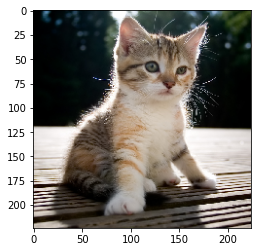

In [3]:
# load sample image
img = tf.keras.preprocessing.image.load_img('./images/cat.jpg', target_size=(224, 224))
img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.

_ = plt.imshow(img)

#### Import Model
For this exercise we will use 4 different Keras pre-trained models: `VGG19`, `ResNet50`, `DenseNet121`, and `MobileNetV2`. By default, the pre-trained models include weights trained in `ImageNet` and takes input shape of `224x224x3`. The top classification layer is also included by default with `softmax` activation. 

In [4]:
import tensorflow.keras.applications as repo

vggnet19 = repo.VGG19()
resnet50 = repo.ResNet50()
dense121 = repo.DenseNet121()
mobilev2 = repo.MobileNetV2()

model_list = [vggnet19, resnet50, dense121, mobilev2]

#### Import ImageNet Class Labels

In [5]:
# import ImageNet class labels

with open("imagenet-class-labels.txt", 'r') as f:
    class_labels = f.read().splitlines()

class_labels = {k:v for k,v in enumerate(class_labels)}
class_labels[285]

'Egyptian Mau'

#### Create a Prediction Helper Function

In [6]:
def predict_result(model, img_arr):

    global class_labels
    preds = model.predict(np.expand_dims(img_arr, axis=0))[0]
    index = np.argmax(preds)
    label = f"{class_labels[index]}({index}): {preds[index]:.4f}"
    return label

for model in model_list:
    print(model.__dict__['_name'].rjust(20), '\t', predict_result(model, img_arr))

               vgg19 	 mosquito net(669): 0.2086
            resnet50 	 nematode(111): 0.1357
         densenet121 	 Egyptian Mau(285): 0.7405
mobilenetv2_1.00_224 	 Egyptian Mau(285): 0.8607


---

### Feature Activation Maps
One of the most direct methods to inspect the activity within a CNN is to visualize the actual feature maps after convolution and ReLU activations. The `tf-explain` library provides the `ExtractActivations` explainer that outputs the tensor of a target layer within a `tf.keras.Model` object.

##### Implementation:
1. select layer that needs to be visualized (layer name string required by `tf-explain`)
2. generate computing graph using the selected layer as final output layer

> ###### ORIGINAL CODE:
>    ```python
>    outputs = [layer.output for layer in model.layers if layer.name in layers_name]
>    activations_model = tf.keras.models.Model(model.inputs, outputs=outputs)
>    activations_model.compile(optimizer="sgd", loss="categorical_crossentropy")
>    return activations_model
>    ```

3. visualize output tensor as needed.

##### Pros:
* can apply to any layer with a feature map output
* see things exactly as the computer sees
* easy to implement and fast to compute (only requires one forward pass)

##### Cons:
* does not provide insights on class-specific information
* does not attribute importance to original pixel feature space
* cannot easily make sense of the prediction decision

##### References:
* (Repo) https://github.com/sicara/tf-explain
* (Code) https://github.com/sicara/tf-explain/blob/master/tf_explain/core/activations.py

In [7]:
from tf_explain.core.activations import ExtractActivations

# define the model explainer - must provide layer name (list of str)
def activation_visualizer(model, img_arr, layer):

    explainer = ExtractActivations(batch_size=1)
    data = np.expand_dims(img_arr, axis=[0,1])
    grid = explainer.explain(data, model, layer)
    return grid

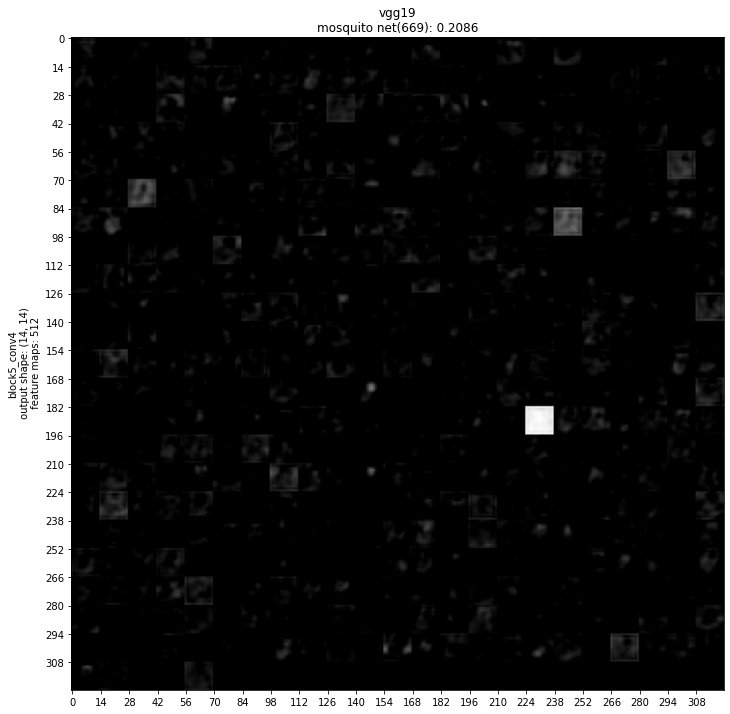

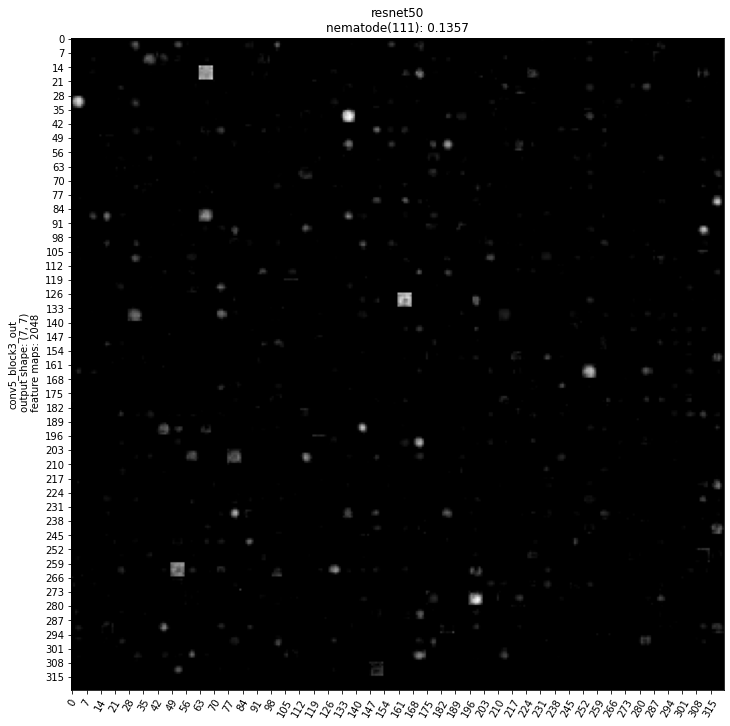

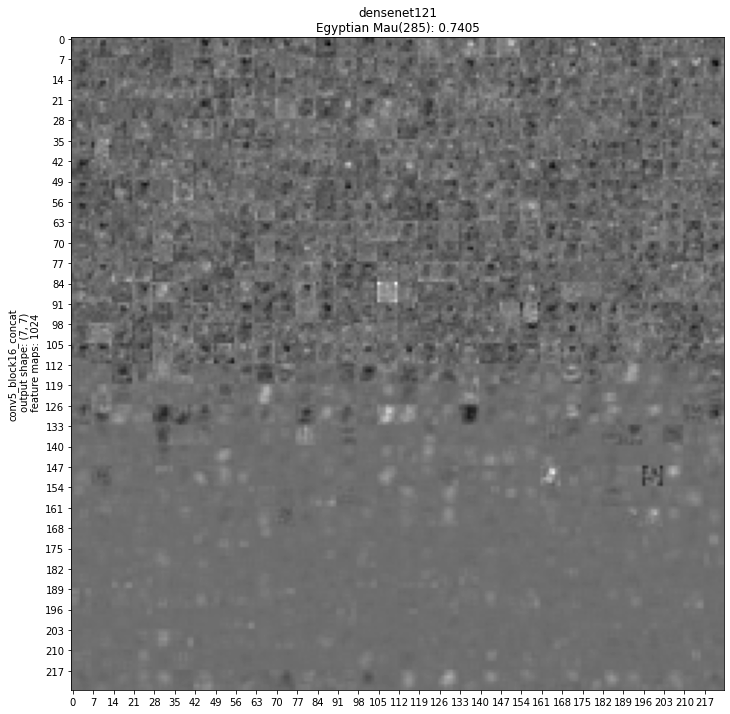

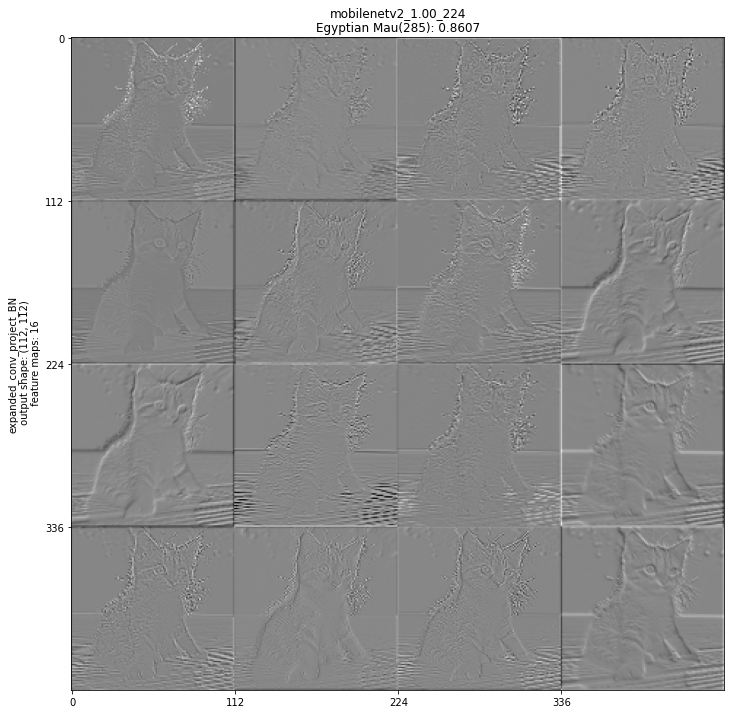

Wall time: 3.63 s


In [8]:
%%time

for i in range(len(model_list)):
    
    model = model_list[i]
    # find all layers within convolutional blocks (another way is by output shape)
    conv_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    # choose the very last convolutional output
    last_layer = conv_names[-1:]
    # get information about output shape
    layer_shape = model.get_layer(last_layer[0]).output.shape
    
    activation = activation_visualizer(model, img_arr, last_layer)
    # match the ticks to output shape
    ticks = np.arange(0, activation.shape[0], step=layer_shape[1])

    plt.figure(figsize=(12,12))
    _ = plt.imshow(activation, cmap='gray')
    _ = plt.title(model.__dict__['_name'] + '\n' + predict_result(model, img_arr))
    _ = plt.ylabel(f"{last_layer[0]}\n output shape: {layer_shape[1:3]}\n feature maps: {layer_shape[-1]}")
    _ = plt.xticks(ticks, rotation=60 if len(ticks) > 32 else 0)
    _ = plt.yticks(ticks)
    plt.show()

As shown above, the 4 models each has a different output shape in the last convolutional layer due to different dimension reduction scheme used: 

|Model|Last Layer|Output Shape|Feature Maps|
|---|:-:|:-:|:-:|
|VGG19          |block5_conv4            |(14,14)  |512 |
|ResNet50       |conv5_block3            |(7,7)    |2048|
|DenseNet121    |conv5_block16_concat    |(7,7)    |1024|
|MobileNetV2    |expanded_conv_project_BN|(112,112)|16  |

If desired, we can further partition out the feature maps and visualize the most activated ones. But the `Grad-CAM` method demonstrated later provides a even better way to visualize the feature maps altogether weighted with gradients of target class prediction scores.

---

### Image-Specific Class Saliency (Vanilla Gradient)
The next most intuitive method is to check the importance of each input pixel on the prediction. 

##### Implementation:
1. remove the softmax activation from output layer in order to use the raw prediction scores
2. calculate the gradient of the target class prediction score with respect to each input pixel

$$w_c = \frac{\partial S_c}{\partial I} \big\rvert_{I=I_0}$$

> ###### ORIGINAL CODE
>    ```python
>    with tf.GradientTape() as tape:
>        inputs = tf.cast(images, tf.float32)
>        tape.watch(inputs)
>        scores = model(inputs)
>        scores_for_class = scores[:, class_index]
>
>    return tape.gradient(scores_for_class, inputs)
>    ```

3. visualize the gradient after normalizing the values (squeezing 3 channels to 1, rescale to RGB 0-255, take absolute value, etc.)

> ###### OIRGINAL CODE
>    ```python
>    grayscale_tensor = tf.reduce_sum(tensor, axis=-1)
>    normalized_tensor = tf.cast(
>        255 * tf.image.per_image_standardization(grayscale_tensor), tf.uint8
>    )
>    return normalized_tensor
>    ```

##### Pros:
* allows analyzing the importance of each pixel from the input feature space
* allows explanation towards prediction of a specific class
* applies to the input feature space of any layer including the initial input layer

##### Cons:
* the results are sometimes not easy to observe
* does not work very well with ReLU activation (results are sparse)

##### Reference:
* (Paper) Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034v2
* (Repo) https://github.com/sicara/tf-explain
* (Code) https://github.com/sicara/tf-explain/blob/master/tf_explain/core/vanilla_gradients.py

In [9]:
from tf_explain.core.vanilla_gradients import VanillaGradients

def gradient_explainer(model, img_arr):
    
    K.clear_session()
    explainer = VanillaGradients()
    data = ([img_arr], None)    # expecting tuple (X, Y)
    
    # clone the model to preserve the original model
    copy_model = tf.keras.models.clone_model(model)
    # remove the softmax activation in the output layer
    copy_model.layers[-1].activation = tf.keras.activations.linear
    
    # add softmax activation as additional layer
    grad_model = tf.keras.models.Sequential(
        [
            copy_model,
            tf.keras.layers.Activation('softmax')
        ],
        name=model.__dict__['_name']+'_grad'
    )

    pred = model.predict(np.expand_dims(img_arr, axis=0))
    grid = explainer.explain(data, grad_model, class_index=np.argmax(pred))
    return grid

Wall time: 9.48 s


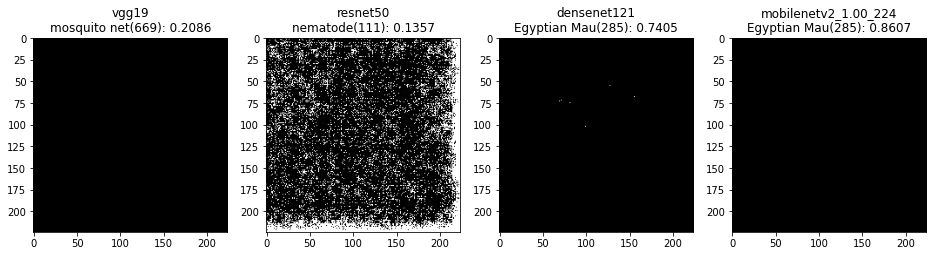

In [10]:
%%time

fig, axes = plt.subplots(1, len(model_list), figsize=(16,5))
for i in range(len(model_list)):
    model = model_list[i]
    pixel_gradient = gradient_explainer(model, img_arr)
    axes[i].set(title=model.__dict__['_name'] + '\n' + predict_result(model, img_arr))
    axes[i].imshow(pixel_gradient, cmap='gray')

Based on the above results, we can't find much useful pattern using the vanilla gradient method. One leading reason is that the pixel-wise gradients corresponding to non-positive features are clipped out due to handling of ReLU:
$$ \frac{\partial f}{\partial X_n} = \frac{\partial f}{\partial X_{n+1}} \mathds{1}(X_n>0)$$

---

### DeconvNet / Backpropagation
The **deconvnet** technique aims to project feature importance into each input space layer-by-layer through reconstruction of the feature maps prior to convolution while highlighting the activation responses. A typical **convolutional block** contains below 4 steps and the deconvnet implements its reconstruction steps accordingly: 
1. convolutional operation 
2. response rectification (usually ReLU) 
3. max pooling (and dimension reduction) 
4. response normalization (usually Batch Normalization)

##### Implementation:
In each **deconvnet layer**, below operations are used to reconstruct the feature maps matching input dimensions from the layer below:
1. **Max Unpooling:** during max pooling, the max positions are recorded in hot-key **switches** for each sliding window; for reconstruction, the unpooling process put the max values on recorded positions (and the rest zero) to preserve the structure of the stimulus.
2. **Rectification:** to preserve the positive responses, the feature maps then was reconstructed with ReLU non-linearity.
3. **Filtering:** the deconvnet then applies **transposed filters** trained in the CNN to the rectified maps with upsampling, mapping features to the previous layer, similarly to the decoding process in autoencoders. 

##### Pros:
* can open up feature maps in any convolutional layer and analyze pixel-specific importance
* preserves more information compared to vanilla gradient method

##### Cons:
* takes a lot of time to compute
* still does not localize activation in a clustered manner

##### References
* (Paper) Visualizing and Understanding Convolutional Networks https://arxiv.org/abs/1311.2901
* (Repo) https://github.com/deel-ai/xplique
* (Docs) https://deel-ai.github.io/xplique/api/deconvnet.html
* (Code) https://github.com/deel-ai/xplique/blob/master/xplique/attributions/deconvnet.py
* (Code) https://github.com/deel-ai/xplique/blob/master/xplique/plots/image.py

The `xplique` library provides an easy-to-use implementation of the devonvnet.

In [11]:
from xplique.attributions import DeconvNet
from xplique.plots import plot_attributions
from xplique.plots.image import _standardize_image

def deconvnet_explainer(model, data):

    copy_model = tf.keras.models.clone_model(model)
    copy_model.layers[-1].activation = tf.keras.activations.linear
    deconv_explainer = DeconvNet(copy_model, output_layer=-1)

    pred = model.predict(data)

    grid = deconv_explainer.explain(data, pred)
    return grid

Wall time: 12.3 s


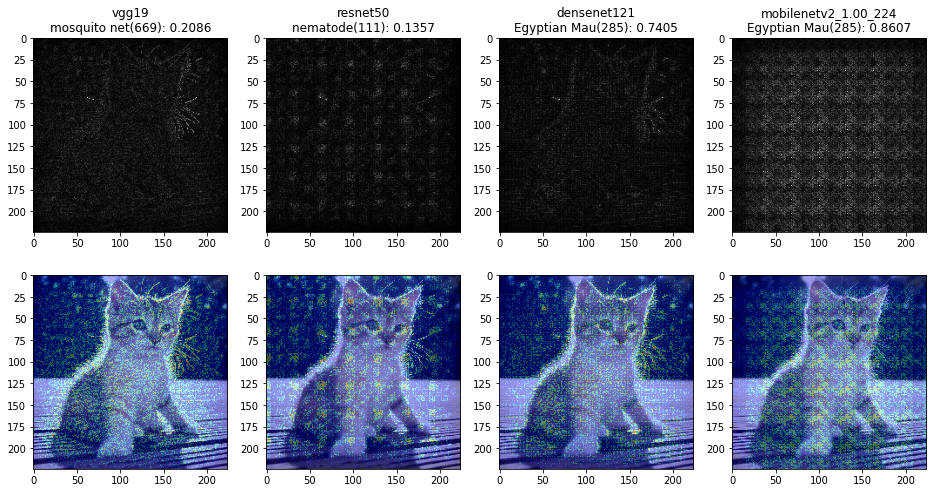

In [12]:
%%time

fig, axes = plt.subplots(2, len(model_list), figsize=(16,8))
for i in range(len(model_list)):

    model = model_list[i]
    data = np.expand_dims(img_arr, axis=0)
    mask = deconvnet_explainer(model, data)
    mask = np.abs(np.mean(mask, axis=-1))

    axes[0, i].set(title=model.__dict__['_name'] + '\n' + predict_result(model, img_arr))
    axes[0, i].imshow(mask[0], cmap='gray')
    axes[1, i].imshow(_standardize_image(img_arr, clip_percentile=0.5))
    axes[1, i].imshow(_standardize_image(mask[0], clip_percentile=0.5), cmap='jet', alpha=0.4)

As shown above, the 4 models each pays attention to different pixels in the example image as revealed by feature reconstruction. 

---

### Gradient-Weighted Class Activation Mapping (Grad-CAM)
Instead of going back to the original input pixel-space through layers of backpropagation, **Grad-CAM** examines the activity in the last convolutional layer, where most knowledge has been learned. Each of the feature maps receives a weight of importance based on their impact on the prediction score (before softmax) in the target class. Upsampling is used to match the dimensions of the input layer to provide an intuitive visualization of feature importance. The earlier published **CAM** method is a special case of Grad-CAM which assumes the CNN exit being Global Average Pooling followed by linear weights before softmax prediction, therefore the linear weights are natural gradients of the class prediction scores. 

##### Implementation:
1. locate the prediction scores corresponding to the target class before softmax $y^c$
2. calculate the gradients of the target class prediction scores with respect to each feature map output by the last convolutional layer $$\alpha_k^c = \frac{1}{Z}\displaystyle\sum_i\displaystyle\sum_j\frac{\partial y^c}{\partial A^k_{ij}}$$
when combined with **guided backpropagation**, only keep values where both activations and gradients are positive

> ###### ORIGINAL CODE
> ```python
> with tf.GradientTape() as tape:
>     inputs = tf.cast(images, tf.float32)
>     tape.watch(inputs)
>     conv_outputs, predictions = grad_model(inputs)
>     loss = predictions[:, class_index]
> grads = tape.gradient(loss, conv_outputs)
> 
> if use_guided_grads:
>     grads = (tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads)
> 
> return conv_outputs, grads
> ```

3. calculate weighted average of the feature maps weighted by the gradients calculated
$$S^c = \frac{1}{Z}\displaystyle\sum_i\displaystyle\sum_j\displaystyle\sum_k \alpha^c_k A^k_{ij}$$

> ###### ORIGINAL CODE
> ```python
> weights = tf.reduce_mean(grad, axis=(0, 1))
> cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
> return cam
> ```

4. upsample the feature maps to match the dimensions of the input image to create ensembled feature heatmap
4. apply the ensembled feature heatmap to the input image

##### Pros:
* delivers very intuitive results with feature localization
* provides discriminative activation information for different target classes
* easy to implement and compute
* can be combined with backpropagation techniques to inspect other layers
* useful for other tasks based on feature localization (e.g. object detection)

##### Cons:
* there is no obvious drawback in Grad-CAM method (my personal favorite!)

##### References:
* (Paper) Learning Deep Features for Discriminative Localization https://ieeexplore.ieee.org/document/7780688
* (Paper) Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization https://arxiv.org/abs/1610.02391
* (Repo) https://github.com/sicara/tf-explain
* (Docs) https://tf-explain.readthedocs.io/en/latest/methods.html#grad-cam
* (Code) https://github.com/sicara/tf-explain/blob/master/tf_explain/core/grad_cam.py

The `tf-explain` library provides a very neat implementation of **Grad-CAM**. In addition to directly calling the `explain` method of the `GradCAM` class, we can also refer to the source code and call other class methods in order to return intermediate calculation values such as the feature maps before upsampling. 

In [13]:
from tf_explain.core.grad_cam import GradCAM

def gradcam_explainer(model, img_arr):
    
    explainer = GradCAM()
    data = ([img_arr], None)
    pred = predict_result(model, img_arr)
    pred = int(pred[pred.index("(") + 1 : pred.rindex(")")])

    # call class methods to return the filters
    outputs, grads = GradCAM.get_gradients_and_filters(
        model, images=np.expand_dims(img_arr, axis=0),
        class_index=pred, 
        layer_name=GradCAM.infer_grad_cam_target_layer(model),
        use_guided_grads=True
    )
    cams = GradCAM.generate_ponderated_output(outputs, grads)[0].numpy()
    mask = explainer.explain(data, model, class_index=pred)
    return cams, mask

Wall time: 4.51 s


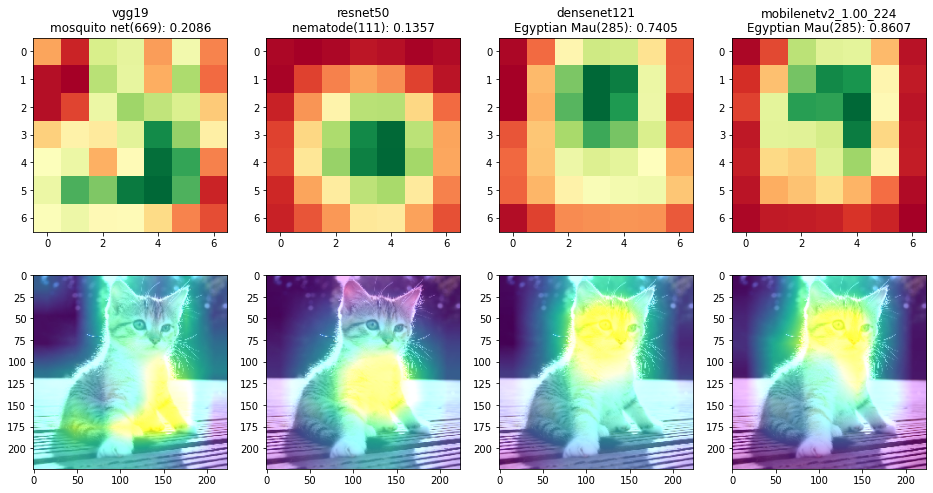

In [14]:
%%time

fig, axes = plt.subplots(2, len(model_list), figsize=(16,8))
for i in range(len(model_list)):
    model = model_list[i]
    
    gradcam, heatmap = gradcam_explainer(model, img_arr)
    axes[0, i].set(title=model.__dict__['_name'] + '\n' + predict_result(model, img_arr))
    axes[1, i].imshow(heatmap, cmap='RdYlGn')
    axes[0, i].imshow(gradcam, cmap='RdYlGn')    

The heatmaps in the first row are the gradient-weighted feature maps output by the last convolutional layer before upsampling, each being 7x7. Using `RdYlGn` (red-yellow-green) colormap, the green pixels indicates most the activated area. It can be observed that the pattern of the feature maps align with the attention area in the masked input image. 

---

### Local Interpretable Model-agnostic Explanations (LIME)
**LIME** is a model-agnostic explanation method. It's based on the assumption that features are **locally linearly separable** even in complex distributions. The paper studied proposes a **Sparse Linear Explanations**, which provides a way to locate **super-pixels** with continuous localization in the context of CNN image classification. 

##### Implementation:
In order to explain the CNN probability prediction $f(x)$ that input $x$ belong to a certain class:
1. define local neighbourhood $z$ around $x$ with proximity measure $\pi_x(z)$, i.e. exponential kernel
$$\pi_x(z) = \exp(-D(x,z)^2/\sigma^2)$$
2. define an interpretable mdoel $g$ such as a linear model (as in paper) or tree model
$$g(z^\prime) = w_g \cdot z^\prime$$
3. approximate the complex model $f$ with the simple model $g$ by minimizing the total loss contructed with 3 factors:
    1. the distance between $f$ and $g$ (cosine for representations, MSE or L2 for classifications)
    2. the proximity measure between $x$ and $z$
    3. the model complexity of $g$
$$\xi(x) = \arg\min L(f,g,\pi_x) + \Omega(g)$$
4. uniformly sample instances of $z$ around $x$ (guided by their interpretable representations such as presense of **super-pixels**) and generate perturbated inputs/
5. calculate $f(z)$ for perturbated inputs repeatedly to be used as training labels for $g$.
6. for image classification with linear model $g$, minimize below loss function 
$$L(f,g,\pi_x) =  \displaystyle\sum_{z, z^\prime} \pi_x(z)(f(z)-g(z^\prime))^2$$
which returns a interpretable linear model $g$ that locally approximates $f$.
7. analyze the importance of each input feature using linear model $g$.

##### Pros:
* provides faithful local explanation near the input neighbourhood and intuitive results
* analyzes both positive and negative support feature-wise (with linear explanation)
* sensitive to different target classes

##### Cons:
* does not provide global explanation beyond the neighbourhood of the input values
* can be pretty time-consuming

##### References:
* (Paper) "Why Should I Trust You?": Explaining the Predictions of Any Classifier https://arxiv.org/abs/1602.04938v3
* (Repo) https://github.com/marcotcr/lime
* (Docs) https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image
* (Code) https://github.com/marcotcr/lime/blob/master/lime/lime_image.py
* (Example) https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [15]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

def lime_explainer(model, img_arr):

    explainer = lime_image.LimeImageExplainer()    
    
    explanation = explainer.explain_instance(
        image=img_arr.astype('double'), 
        classifier_fn=model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=100,
    )

    find_super_pixels = partial(
        explanation.get_image_and_mask, 
        label=explanation.top_labels[0],                # label to explain
        num_features=5, 
        hide_rest=True,
    )
        
    # find boundary for super pixels with positive support and mask the rest
    temp, mask = find_super_pixels(positive_only=True, negative_only=False)
    positive_support = mark_boundaries(temp / 2 + 0.5, mask)
    
    # find boundary for super pixels with negative support and mask the rest
    temp, mask = find_super_pixels(positive_only=False, negative_only=True)
    negative_support = mark_boundaries(temp / 2 + 0.5, mask)
    
    # find heatmap
    dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
    support_heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    
    return positive_support, negative_support, support_heatmap

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 21.7 s


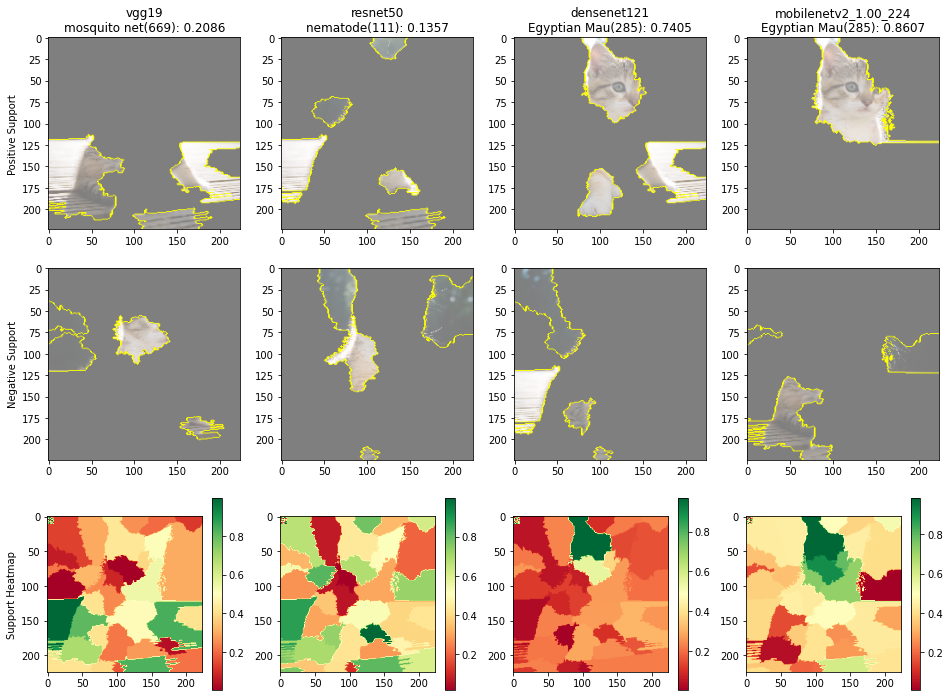

In [16]:
%%time

fig, axes = plt.subplots(3, len(model_list), figsize=(16,12))
for i in range(len(model_list)):
    model = model_list[i]
    
    positive_mask, negative_mask, heatmap = lime_explainer(model, img_arr)
    axes[0, i].set(title=model.__dict__['_name'] + '\n' + predict_result(model, img_arr))
    axes[0, i].imshow(positive_mask)
    axes[1, i].imshow(negative_mask)
    axes[2, i].imshow(heatmap, cmap='RdYlGn')
    pcm = axes[2, i].pcolormesh(np.random.random((10, 10)), cmap='RdYlGn')
    fig.colorbar(pcm, ax=axes[2, i])

_ = axes[0, 0].set_ylabel('Positive Support')
_ = axes[1, 0].set_ylabel('Negative Support')
_ = axes[2, 0].set_ylabel('Support Heatmap')

It can be observed from above masked images that the two models with correct predictions `DenseNet121` and `MobileNetV2` both have strong positive support generated from pixel features around the cat's face area, in contrast to the two models with wrong predictions `VGG19` and `ResNet50`. 

---

### Shapley Additive Explanation (SHAP) Values
SHAP is a **permutation-based** model explanation method that reveals feature importance in **additive** manner. Though the original definition of **Shapley Values** is model-agnostic, it can have optimal implementation based on the actual model structure (e.g. TreeSHAP). The core logic of original **Shapley Values** is to calculate the contribution of each feature in all possible permutations of feature appearance. For CNN image classification tasks, SHAP can be implemented in combination with LIME to explain pixel-wise feature importance while preserving its additive property.

##### Implementation:
1. Similarly to LIME, SHAP aims to employ a simpler interpretable model to explain the complex model like CNN. The interpretable model is defined as a linear function of $M$ binary variables: 
$$g(z^\prime) = \phi_0 + \displaystyle\sum_{i=1}^{M}\phi_i z_i^\prime, \quad z^\prime \in \{0,1\}^M$$
and the weights $\phi_i$ will correspond to the importance of each feature. 

2. Next we need the weights to reflect the additive Shapley Value defined as:
$$\phi_i(f,x) = \displaystyle\sum_{z^\prime\subseteq x^\prime} \frac{|z^\prime|!(M-|z^\prime|-1)!}{M!}[f_x(z^\prime)-f_x(z^\prime\backslash i)] $$
where $|z^\prime|$ is the number of non-zero entries in $z^\prime$, and $z^\prime\subseteq x^\prime$ represents all $z^\prime$ vectors where its non-zero entries are a subset of the non-zero entries in $x^\prime$.

3. Define proximity measure $\pi_x$ using below estimate kernel:
$$\pi_{x^\prime}(z^\prime) = \frac{(M-1)}{\left.M \choose |z^\prime|\right. |z^\prime|(M-|z^\prime|)}$$

4. Optimized with linear regression using the LIME method, the above defined model $g$ provides a locally accurate explanation with additive property. The combined technique is known as **Kernel SHAP**.

##### Pros:
* provides locally accurate feature importance
* provides unique/consistent feature importance for each prediction
* maps missing feature (value 0) to 0 feature importance (no impact)
* SHAP values analyzed over different inputs can be clustered to provide global insights
* can be applied to many different types of models and combined with other explanation methods (e.g. DeepLIFT)

##### Cons:
* slow to compute but can implement sampling-based estimates. 

##### References:
* (Paper) A Unified Approach to Interpreting Model Predictions https://arxiv.org/abs/1705.07874v2
* (Repo) https://github.com/slundberg/shap
* (Example) https://github.com/slundberg/shap/blob/master/notebooks/image_examples/image_classification/

In [17]:
import shap
display(shap.__version__)

def shap_explainer(model, img_arr):

    # define a masker that is used to mask out partitions of the input image. 
    masker = shap.maskers.Image("blur(128,128)", img_arr.shape)

    global class_labels
    # create an explainer with model and image masker 
    explainer = shap.Explainer(model, masker, output_names=list(class_labels.values()))

    # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
    shap_values = explainer(
        np.expand_dims(img_arr, axis=0), 
        max_evals=500,
        batch_size=50,
        outputs=shap.Explanation.argsort.flip[:5]
    )

    return shap_values

'0.40.0'

vgg19


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:33, 33.17s/it]                                                                            


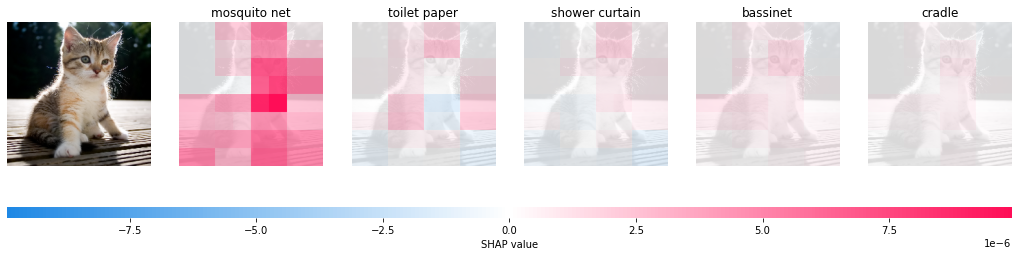

resnet50


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.68s/it]                                                                            


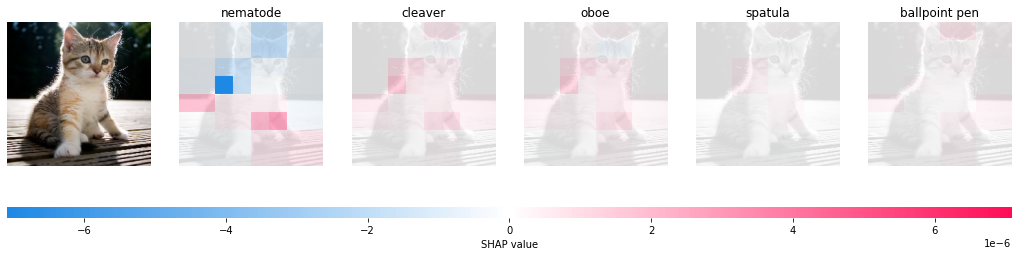

densenet121


  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.72s/it]                                                                            


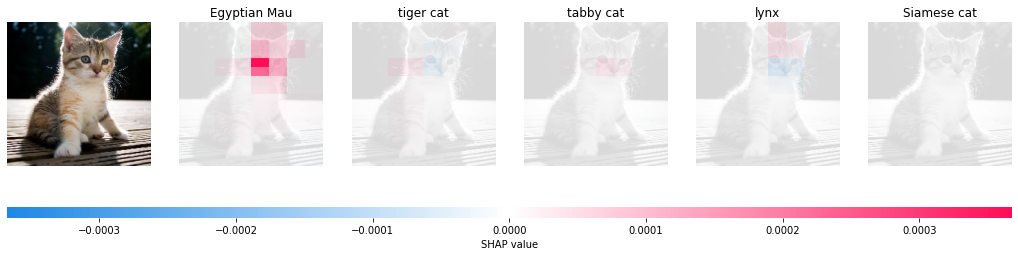

mobilenetv2_1.00_224


  0%|          | 0/248 [00:00<?, ?it/s]

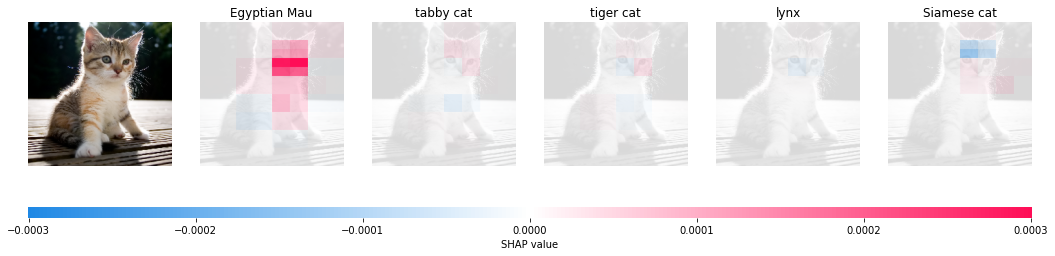

Wall time: 1min 19s


In [18]:
%%time

for i in range(len(model_list)):
    model = model_list[i]
    print(model.__dict__['_name'])
    shap_values = shap_explainer(model, img_arr)
    shap.image_plot(shap_values)

Now it totally makes sense to me why some models think it's a cat and some think it's a mosquito net!